In [1]:
import os, sys
from tqdm import tqdm
import numpy as np
import itertools
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

import ants

from models import AAE, Encoder, Decoder, Discriminator
from tools.config import Config, read_conf
from train import train, generator
from tools.dataset import MRTDataset
from models import AAE

In [2]:
%%bash
ls /root/HCP

T2w_restore
T2w_restore.2
T2w_restore_brain


In [3]:
%%bash
ls /root/BRATS

BRATS2015_Training.zip
HGG
LGG


In [4]:
config = read_conf(f'/root/cAAE/config/config_test.json')
def get_train_model(config):
    dataset, img_shape = generator(copy.deepcopy(config), health_flg=True, dat_flg=True)
    dataloader, img_shape = generator(copy.deepcopy(config), health_flg=True, dat_flg=False)
    print(img_shape)
    config.transforms += {'img_shape': img_shape.copy()}
    config.train.n_epochs = 200
    model = AAE(config, train_flg=True)
    return model, dataset, dataloader

def get_test_model(config):
    dataset, img_shape = generator(copy.deepcopy(config), health_flg=False, dat_flg=True)
    dataloader, img_shape = generator(copy.deepcopy(config), health_flg=False, dat_flg=False)
    print(img_shape)
    config.transforms += {'img_shape': img_shape.copy()}
    model = AAE(config, train_flg=False)
    return model, dataset, dataloader

def test_one(config, load_path):
    dataset, img_shape = generator(config, health_flg=False, dat_flg=True)
    config.transforms += {'img_shape': img_shape.copy()}
    model = AAE(config)
    model.load(load_path)
    return model

In [5]:
%%bash
ls /root/weights
# rm /root/weights/*

decoder
discriminator
encoder


In [6]:
train_model, train_dataset, train_dataloader = get_train_model(copy.deepcopy(config))
test_model, test_dataset, test_dataloader = get_test_model(copy.deepcopy(config))

[260, 64, 64]
[Cuda: True]
[155, 64, 64]
[Cuda: True]


In [7]:
save_path = '/root/weights'
load_path = save_path
one_model = test_one(config, load_path)

[Cuda: True]


In [8]:
def test_one(self, dataset, idx=None):
    test_person = dataset.person_list[idx] if idx else dataset.get_random()
#     test_brain = test_person.get_ants(np_flg=False)
#     test_tumor = test_person.get_tumor(np_flg=False)
    real_img = Variable(test_brain(self.transform).type(self.Tensor))
    decoded_img = self.decoder(self.encoder(real_img))
    
    decoded_img_np = decoded_img.cpu().detach().permute(1, 2, 0).numpy()
    return test_brain(self.transform)

    decoded_img = self.decoder(self.encoder(real_img))
    decoded_img_np = decoded_img.cpu().detach().permute(1, 2, 0).numpy()

#     scale_test_brain = trf(test_brain) if trf else test_brain
#     scale_test_tumor = trf(test_tumor) if trf else test_tumor
#     # scale_test_brain = ants.iMath_normalize(test_brain).resample_image(decoded_img_np.shape, 1, 0)
#     # scale_test_tumor = ants.iMath_normalize(test_tumor).resample_image(decoded_img_np.shape, 1, 0)

#     # g_loss = self.pixelwise_loss(decoded_imgs, real_imgs)
#     return abs(scale_test_brain - decoded_img_np), scale_test_tumor
one_model.test_one = test_one

In [14]:
# test_dataset.get_random(ps_flg=True)
test_dataset.get_random(ps_flg=False).shape

torch.Size([155, 64, 64])

In [42]:
test_brain(test_dataset.transform)

TypeError: 'ANTsImage' object is not callable

In [13]:
one_model.test_one(one_model, test_dataset)

b43553bb-441f-47f7-846b-b114d1: pat474_brain

In [14]:
test_person = one_model.test_one(one_model, test_dataset)
train_person = train_dataset.get_random()

In [15]:
train_brain = train_person.get_ants(np_flg=False)
test_brain = test_person.get_ants(np_flg=False)
test_tumor = test_person.get_tumor(np_flg=False)

In [16]:
test_brain, test_tumor, train_brain

(ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.], ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.], ANTsImage (RPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (260, 311, 260)
 	 Spacing    : (0.7, 0.7, 0.7)
 	 Origin     : (-90.0, 126.0, -72.0)
 	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.])

In [ ]:
plt.imshow(train_datase[0])

In [17]:
ll = 0
for i in train_dataloader:
    ll = i
    break
ll.shape, ll.numpy().shape

(torch.Size([2, 260, 64, 64]), (2, 260, 64, 64))

In [18]:
lll = 0
for i in test_dataloader:
    lll = i
    break
lll.shape, lll.numpy().shape

(torch.Size([1, 155, 64, 64]), (1, 155, 64, 64))

In [22]:
u = ll[0].numpy()
v = lll[0].numpy()
u.shape, v.shape

((260, 64, 64), (155, 64, 64))

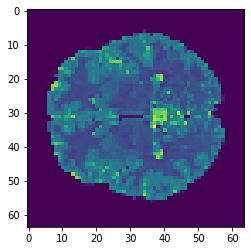

In [29]:
plt.imshow(u[100, :, :])

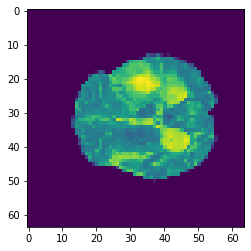

In [30]:
plt.imshow(v[70, :, :])

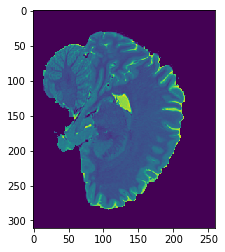

In [39]:
plt.imshow(train_brain.numpy()[100, :, :])
# train_brain.numpy().shape, test_brain.numpy().shape 

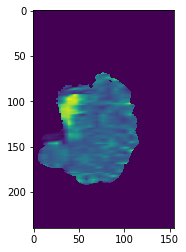

In [40]:
plt.imshow(test_brain.numpy()[70, :, :])

In [218]:
config = read_conf(f'/root/cAAE/config/config_test.json')
dataset_f, img_shape_f = generator(config, health_flg=False, dat_flg=True)
config.transforms += {'img_shape': img_shape_f.copy()}
config.train.batch_size = 1
model2 = AAE(config)
model2

[Cuda: True]


cuda: True
config: 
_______
'batch_size': 1
'latent_dim': 128
'n_epochs': 200
'lr': 0.0002
'b1': 0.5
'b2': 0.999
'sample_interval': 400
'max_batch': 42
'Tensor': <class 'torch.cuda.FloatTensor'>
_______

In [219]:
load_path = save_path
model2.load(load_path)

In [221]:
#const
import matplotlib.pyplot as plt
a = 0.5
n = 0
s = 100

In [222]:
test_person = dataset_f.person_list[n]
test_brain = ants.image_read(test_person.path)
test_tumor = test_person.get_tumor(np_flg=False)

In [223]:
real_img = Variable(dataset_f[n].type(model2.Tensor))
encoded_img = model2.encoder(real_img)
decoded_img = model2.decoder(encoded_img)
decoded_img_np = decoded_img.cpu().detach().permute(1, 2, 0).numpy()
decoded_img_np.shape

(64, 64, 155)

In [224]:
scale_test_brain = ants.iMath_normalize(test_brain).resample_image(decoded_img_np.shape, 1, 0)
scale_test_tumor = ants.iMath_normalize(test_tumor).resample_image(decoded_img_np.shape, 1, 0)

In [225]:
decoded_img_ants = scale_test_brain.new_image_like(decoded_img_np)

In [226]:
ans = decoded_img_ants[:, :, s] - scale_test_brain[:, :, s]
ans[abs(ans) < a] = 0

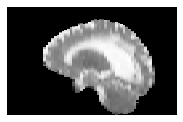

In [227]:
scale_test_brain.plot(slices=s, axis=0)

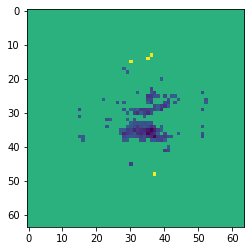

In [228]:
plt.imshow(ans)

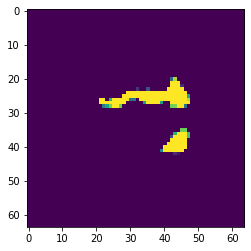

In [229]:
plt.imshow(scale_test_tumor.numpy()[:, :, s])

In [180]:
dataset_tt[0].numpy().shape

(260, 64, 64)

In [118]:
dataset_tt, img_shape_t = generator(config, health_flg=True, dat_flg=True)

In [155]:
t = ants.image_read(dataset_tt.person_list[0].path)
t

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (260, 311, 260)
	 Spacing    : (0.7, 0.7, 0.7)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [124]:
f = ants.image_read(dataset_f.person_list[0].path)
f

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, -239.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [156]:
t.set_direction(ants.get_direction(f))

In [157]:
t.get_orientation(), f.get_orientation()

('RAI', 'RAI')

In [160]:
t

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (260, 311, 260)
	 Spacing    : (0.7, 0.7, 0.7)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

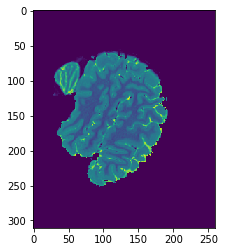

In [176]:
plt.imshow(t.numpy()[200, :, :])

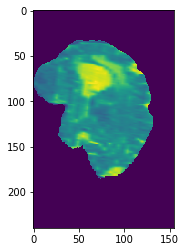

In [177]:
plt.imshow(np.flip(f.numpy(), axis=1)[150, :, :])

In [186]:
dataset_f[0].shape, dataset_tt[0].shape

(torch.Size([155, 64, 64]), torch.Size([260, 64, 64]))

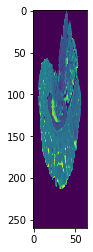

In [193]:
plt.imshow(dataset_tt[0].numpy()[:, 32, :])

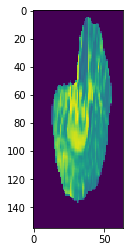

In [194]:
plt.imshow(dataset_f[0].numpy()[:, 32, :])

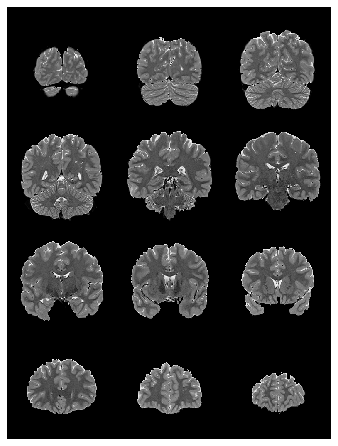

In [163]:
t.plot(axis=1)

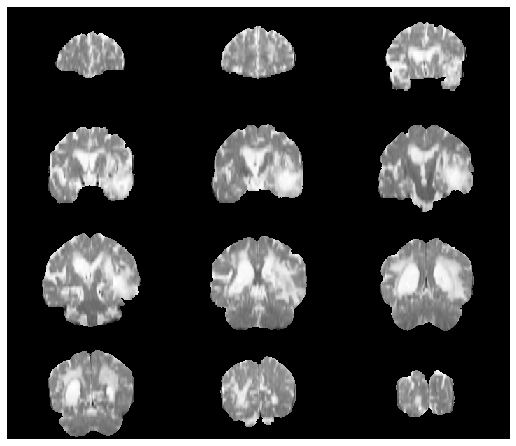

In [132]:
f.plot(axis=1)

In [ ]:
imgs = batch.reshape(-1, self.img_shape[1], self.img_shape[2])


# Configure input
real_imgs = Variable(imgs.type(self.Tensor))

encoded_imgs = self.encoder(real_imgs)
decoded_imgs = self.decoder(encoded_imgs)

# Loss measures generator's ability to fool the discriminator
g_loss = \
    0.001 * self.adversarial_loss(self.discriminator(encoded_imgs), valid) + \
    0.999 * self.pixelwise_loss(decoded_imgs, real_imgs)